In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
save_path = "plots"
output_path = "outputs"
if not os.path.exists(save_path):
    os.mkdir(save_path)

In [5]:
store = {
    "ml": {
        "rf": "rf",
        "lgb": "lgb_tuned",
        "xgb": "xgb_tuned",
    },
    "nn": {
        "mlp": "mlp",
        "lstm": "lstm",
        "gru": "gru",
    },
}

Paziente con MAE migliore per ml: 3812 (MAE media: 8.70)


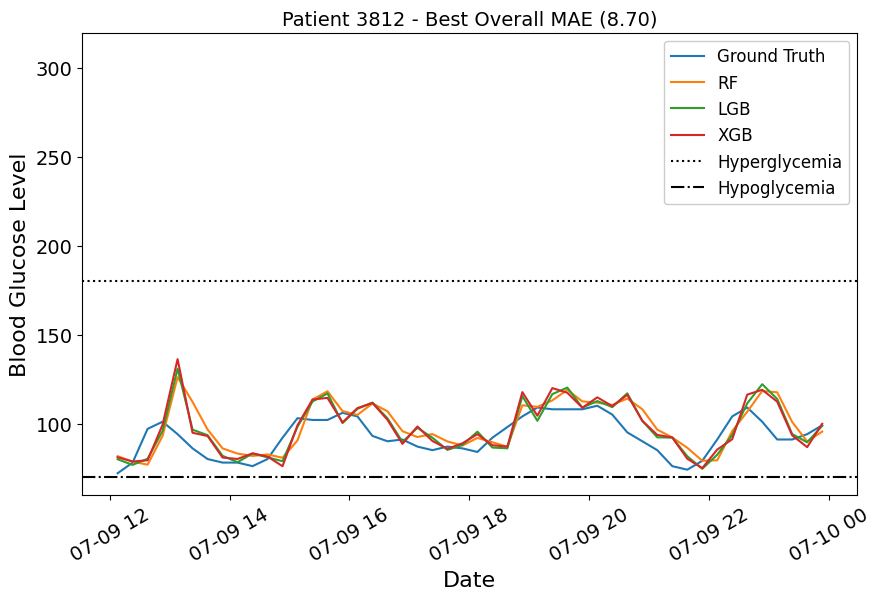

Paziente con MAE migliore per nn: 3812 (MAE media: 8.44)


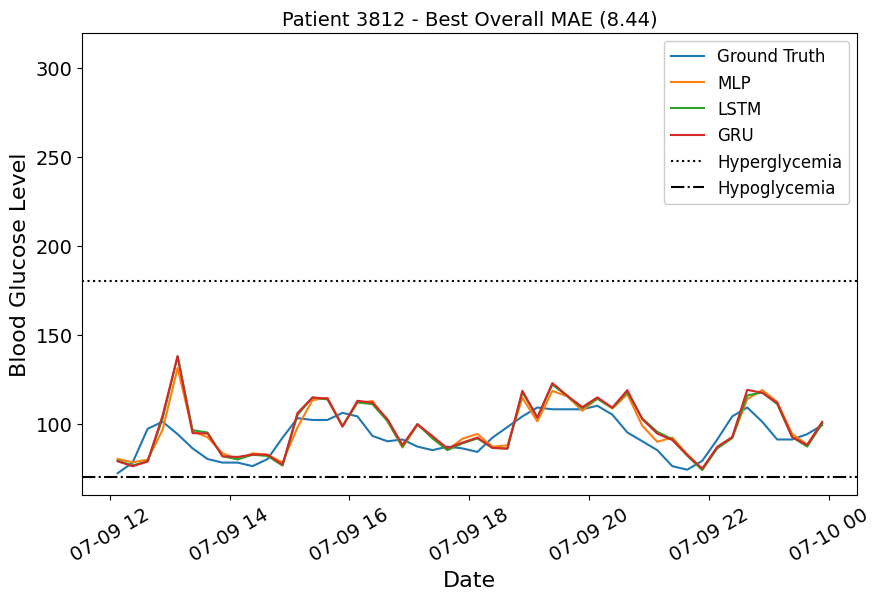

In [6]:
for plt_name, outputs in store.items():
    fig = plt.figure(figsize=(10, 6))

    # Calcola la MAE media per ogni paziente attraverso tutti i modelli
    patient_maes = {}

    for i, (key, items) in enumerate(outputs.items()):
        df = pd.read_csv(f"{output_path}/{items}_output.csv")
        df["Timestamp"] = pd.to_datetime(df["Timestamp"])

        # Calcola MAE per ogni paziente per questo modello
        for patient_id in df["Patient_ID"].unique():
            patient_data = df[df["Patient_ID"] == patient_id]
            mae = np.mean(np.abs(patient_data["target"] - patient_data["y_pred"]))

            if patient_id not in patient_maes:
                patient_maes[patient_id] = []
            patient_maes[patient_id].append(mae)

    # Trova il paziente con la MAE media più bassa
    avg_patient_maes = {pid: np.mean(maes) for pid, maes in patient_maes.items()}
    best_patient = min(avg_patient_maes, key=avg_patient_maes.get)

    print(
        f"Paziente con MAE migliore per {plt_name}: {best_patient} (MAE media: {avg_patient_maes[best_patient]:.2f})"
    )

    # Plotta la serie per il paziente migliore
    for i, (key, items) in enumerate(outputs.items()):
        df = pd.read_csv(f"{output_path}/{items}_output.csv")
        df["Timestamp"] = pd.to_datetime(df["Timestamp"])

        a = df[df["Patient_ID"] == best_patient]
        most_day = a["Timestamp"].dt.date.value_counts().index[0]
        b = a[a["Timestamp"].dt.date == most_day].sort_values("Timestamp")
        b = b.iloc[int(len(b) / 2) :]

        if i == 0:
            plt.plot(b["Timestamp"], b["target"], label="Ground Truth")
        plt.plot(b["Timestamp"], b["y_pred"], label=key.upper())

    plt.axhline(y=180, color="black", linestyle=":", label="Hyperglycemia")
    plt.axhline(y=70, color="black", linestyle="-.", label="Hypoglycemia")
    plt.xticks(rotation=30, fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Date", fontsize=16)
    plt.ylabel("Blood Glucose Level", fontsize=16)
    plt.gca().set_ylim(60, 320)
    plt.legend(fontsize=12, loc="upper right", framealpha=1.0)
    plt.title(
        f"Patient {best_patient} - Best Overall MAE ({avg_patient_maes[best_patient]:.2f})",
        fontsize=14,
    )
    plt.savefig(f"{save_path}/{plt_name}_plot.pdf", format="pdf")
    plt.show()